In [1]:
import pandas as pd
import pandahouse as ph
import swifter
import hashlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250820',
'user':'student',
'password':'dpo_python_2020'
}

q = """
SELECT uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-08-02' and '2025-08-08' 
"""

# Вытащили пользователей
ph.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,49814


In [3]:
# Запрос из БД по 1 и 2 группе с подсечтом лайков/просмотров,поюзерный расчет метрики CTR
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-08-02' and '2025-08-08'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
...,...,...,...,...,...
19892,1,132567,52,326,0.159509
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [4]:
# Распределение по группам равномерно
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [5]:
# Средннее значение CTR по группам
df[df.exp_group == 1].ctr.mean(),df[df.exp_group == 2].ctr.mean()

(0.216773994120072, 0.2161016893237817)

In [9]:
# Разница средних
diff_mean=df[df.exp_group == 2].ctr.mean()-df[df.exp_group == 1].ctr.mean()
diff_mean.round(5)

-0.00067

[Text(0.5, 1.0, 'Распределение CTR в группах 1 и 2'),
 Text(0.5, 0, 'CTR'),
 Text(0, 0.5, 'Count')]

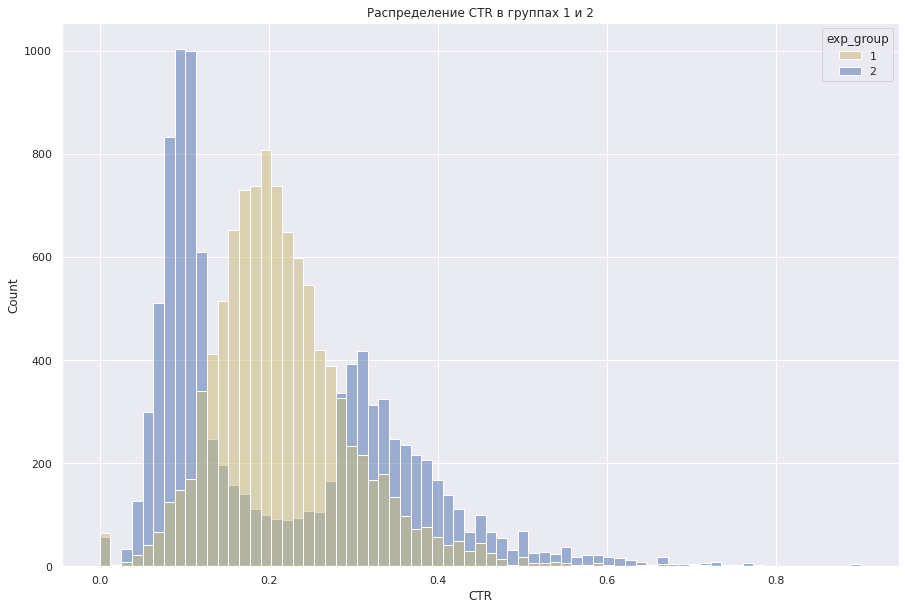

In [10]:
# Гистограмма распределения CTR по группам 2 и 1
sns.set(rc={'figure.figsize':(15,10)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['y', 'b'],
              alpha=0.5,
              kde=False)
groups.set(title='Распределение CTR в группах 1 и 2',
           xlabel='CTR', 
           ylabel='Count')


In [11]:
t_stat, p_val=stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
t_stat, p_val

(0.4051491913112757, 0.685373331140751)

In [12]:
# По результатам т-теста,различий нет
a=0.05
if p_val>=a:
 print('Различия между группами статистически незначимы')
else:
  print('Различия есть,нулевая гипотеза не верна')   

Различия между группами статистически незначимы


In [13]:
y_stat, y_pval=stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)
y_stat, y_pval

(55189913.0, 4.632205841806026e-45)

In [9]:
# По результатам теста Манна-Уитни различия есть
a=0.05
if y_pval>=a:
 print('Различия между группами статистически незначимы')
else:
  print('Различия есть,нулевая гипотеза не верна')   

Различия есть,нулевая гипотеза не верна


In [14]:
# Создание функции для генерации выборок и подсчета глобальных CTR
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [17]:
# Перевод столбцов в нампи массив для корректной работы функции 
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [18]:
# Расчет глобальных CTR в группах
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

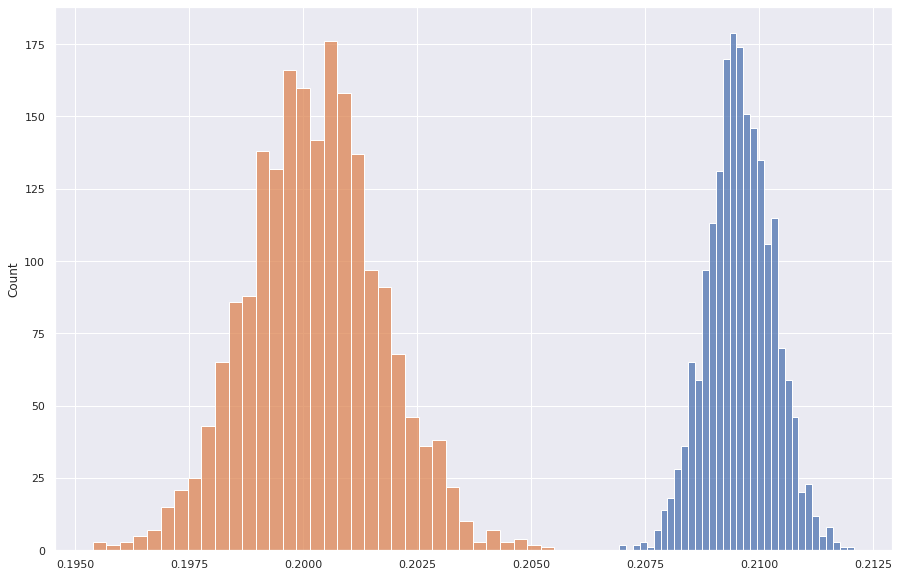

In [19]:
# Гистограмма распределения массивов CTR по группам
sns.histplot(ctr1)
sns.histplot(ctr2)

In [20]:
# разница массивов CTR между 2 и 1 группой
diff_ctr=ctr2 - ctr1
diff_ctr

array([-0.01038878, -0.01017316, -0.01040154, ..., -0.00987139,
       -0.01023009, -0.00940457])

<Axes: ylabel='Count'>

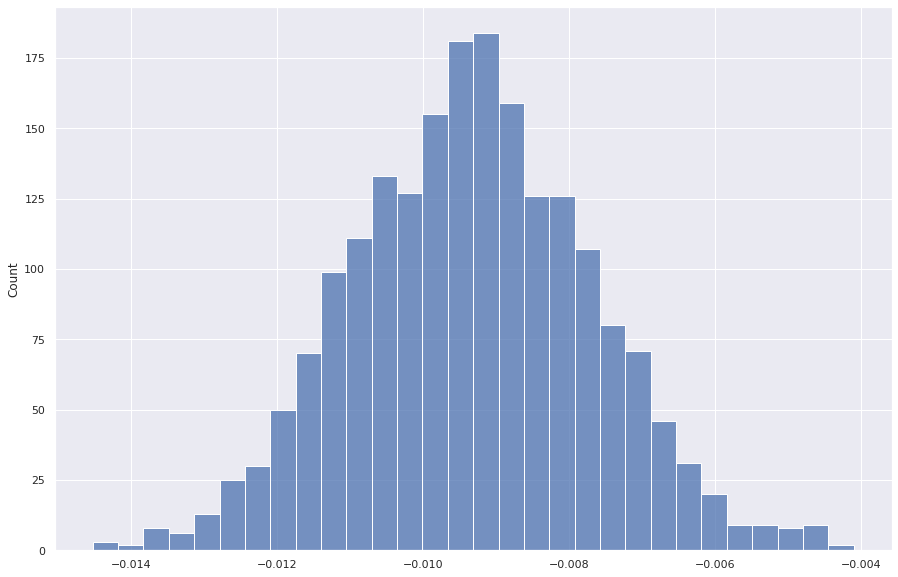

In [21]:
# Гистограмма распределения разницы массивов CTR между 2 и 1 группой
sns.histplot(diff_ctr)

In [25]:
# Вычесления нижней границы 2.5 прецентиля и верхней границы 97.5 прецентиля
low, high = np.percentile(diff_ctr, [2.5, 97.5])
print('95% доверительный интервал:', '[',low.round(4),',',high.round(4),']')

95% доверительный интервал: [ -0.0125 , -0.0061 ]


In [26]:
# Интерпритация результатов:массив данных < 0 ,1 группа лучше
if low > 0:
    print("Эксперимент успешен: 2 группа (тестовая) лучше")
elif high < 0:
    print("Эксперимент не успешен: 1 группа (контрольная) лучше")
else:
    print("Нет статистически значимых различий")

Эксперимент не успешен: 1 группа (контрольная) лучше


In [27]:
# Создание функции для вычесления сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [28]:
# Рассчет CTR по группам
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [29]:
# Создание копий выборок по группам
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [30]:
# Создание столбца с выселением сглаженного CTR построчно для 1 группы
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

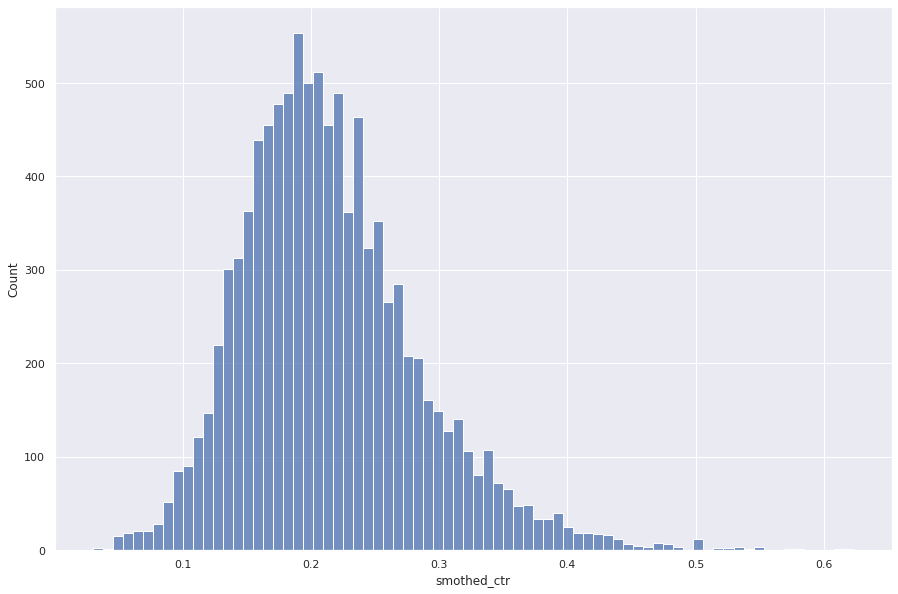

In [31]:
# Гистограмма распределения сглаженного CTR в 1 группе
sns.histplot(group1.smothed_ctr, 
             kde = False)

In [32]:
# Создание столбца с выселением сглаженного CTR построчно для 2 группы
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

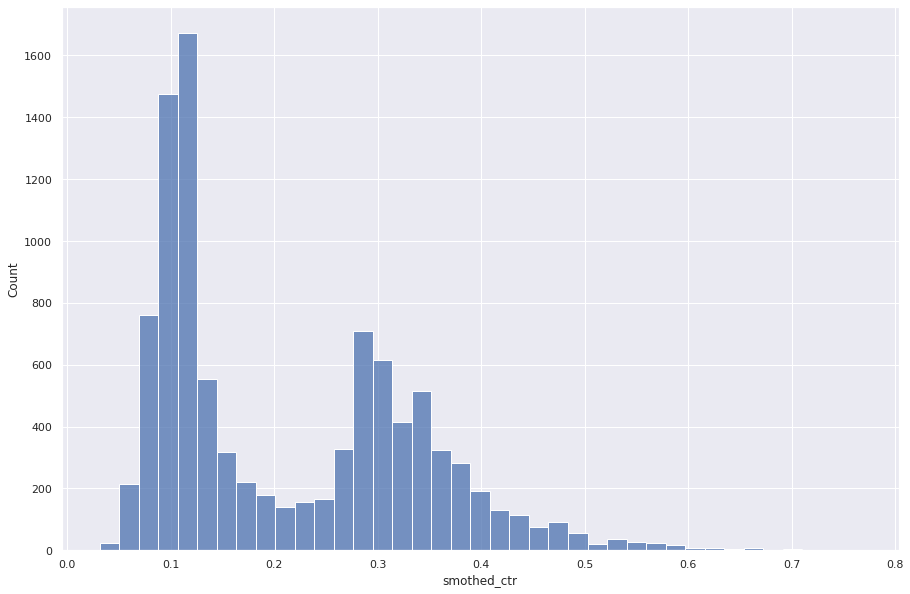

In [33]:
# Гистограмма распределения сглаженного CTR для 2 группы
sns.histplot(group2.smothed_ctr, 
             kde = False)

In [34]:
# Т-тест на сглаженных CTR
t_stat, p_val=stats.ttest_ind(group1[group1.exp_group == 1].smothed_ctr,
                group2[group2.exp_group == 2].smothed_ctr,
                equal_var=False)
t_stat, p_val

(1.9460491517027683, 0.05166679015318526)

In [35]:
# Результат Т-теста на сглаженных CTR
a=0.05
if p_val>=a:
 print('Различия между группами статистически незначимы')
else:
  print('Различия есть,нулевая гипотеза не верна')   

Различия между группами статистически незначимы


In [37]:
# Разделение каждой группы на 50 бакетов и расчет бакетного CTR для каждой
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-08-02' and '2025-08-08' 
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_gr = ph.read_clickhouse(q, connection=connection)
bucket_gr.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.200592
1,2,0,0.196510
2,1,1,0.208799
3,2,1,0.210375
4,1,2,0.204632


In [38]:
# Т-тест на бакетном преобразовании
t_stat, p_val=stats.ttest_ind(bucket_gr[bucket_gr.exp_group == 1].bucket_ctr,
                bucket_gr[bucket_gr.exp_group == 2].bucket_ctr,
                equal_var=False)
t_stat, p_val

(5.614819358149381, 4.592644937473873e-07)

In [39]:
# Результат Т-теста на бакетных CTR
a=0.05
if p_val>=a:
 print('Различия между группами статистически незначимы')
else:
  print('Различия есть,нулевая гипотеза не верна')   

Различия есть,нулевая гипотеза не верна


In [40]:
# Тест Манна-Уитни на бакетном преобразовании
y_stat, y_pval=stats.mannwhitneyu(bucket_gr[bucket_gr.exp_group == 1].bucket_ctr,
                bucket_gr[bucket_gr.exp_group == 2].bucket_ctr)
y_stat, y_pval

(1997.0, 2.6576427804010095e-07)

In [41]:
# Результат теста Манна-Уитни на бакетных CTR
a=0.05
if p_val>=a:
 print('Различия между группами статистически незначимы')
else:
  print('Различия есть,нулевая гипотеза не верна')   

Различия есть,нулевая гипотеза не верна


In [42]:
# Общие показатели квантилей по группам
q = """
SELECT 
    exp_group,
    quantileExact(0.1)(ctr) as ctr_10,  -- 10-й перцентиль
    quantileExact(0.5)(ctr) as ctr_50,  -- медиана
    quantileExact(0.9)(ctr) as ctr_90,  -- 90-й перцентиль (уже есть у вас)
    quantileExact(0.95)(ctr) as ctr_95, -- 95-й перцентиль
    avg(ctr) as mean_ctr                -- среднее для сравнения
FROM (
    SELECT 
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-08-02' and '2025-08-08' 
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id
)
GROUP BY exp_group
"""

In [43]:
quant_group = ph.read_clickhouse(q, connection=connection)
quant_group

,exp_group,ctr_10,ctr_50,ctr_90,ctr_95,mean_ctr
0,1,0.12766,0.205882,0.321429,0.366667,0.216774
1,2,0.07500,0.153285,0.400000,0.462264,0.216102


In [44]:
# Показатели квантилей по бакетам
q = """
SELECT 
    exp_group,bucket,
    quantileExact(0.1)(ctr) as ctr_10,  -- 10-й перцентиль
    quantileExact(0.5)(ctr) as ctr_50,  -- медиана
    quantileExact(0.9)(ctr) as ctr_90,  -- 90-й перцентиль (уже есть у вас)
    quantileExact(0.95)(ctr) as ctr_95, -- 95-й перцентиль
    avg(ctr) as mean_ctr                -- среднее для сравнения
FROM (
    SELECT 
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-08-02' and '2025-08-08' 
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id
)
GROUP BY exp_group,bucket
"""

In [62]:
df_q = ph.read_clickhouse(q, connection=connection)
df_q

(0.1538461538461538, 0.2049737411183194)

In [69]:
# Медианные значения по 50 квантилю
df_q[df_q.exp_group==2].ctr_50.median(),df_q[df_q.exp_group==1].ctr_50.median()

(0.1538461538461538, 0.2049737411183194)

In [67]:
# Разница медиан
diff_med=df_q[df_q.exp_group==2].ctr_50.median()-df_q[df_q.exp_group==1].ctr_50.median()
diff_med.round(4)

-0.0511

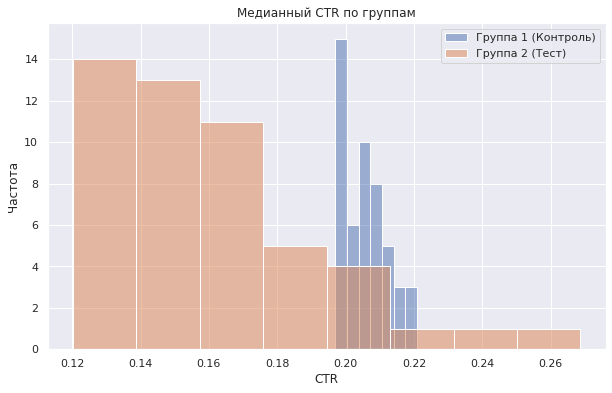

In [57]:
# Гистограмма распределения по 50 перцентилю (медиана)
plt.figure(figsize=(10, 6))

sns.histplot(df_q[df_q.exp_group == 1].ctr_50, 
             alpha=0.5, label='Группа 1 (Контроль)')
sns.histplot(df_q[df_q.exp_group == 2].ctr_50, 
             alpha=0.5, label='Группа 2 (Тест)')

plt.legend() 
plt.title('Медианный CTR по группам')
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.savefig('my_plot1.png') 
plt.show()


Text(0, 0.5, 'Частота')

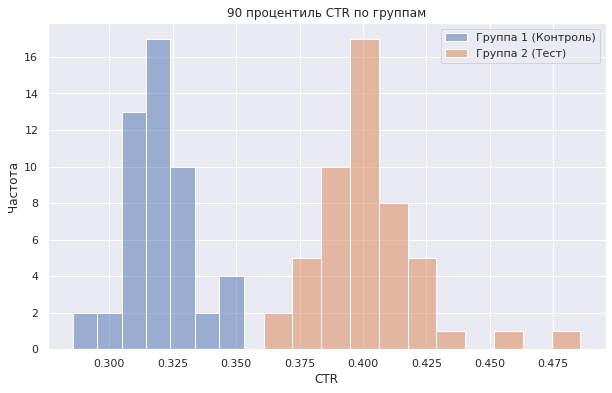

In [72]:
# Гистограмма распределения по 90 перцентилю
plt.figure(figsize=(10, 6))

sns.histplot(df_q[df_q.exp_group == 1].ctr_90, 
             alpha=0.5, label='Группа 1 (Контроль)')
sns.histplot(df_q[df_q.exp_group == 2].ctr_90, 
             alpha=0.5, label='Группа 2 (Тест)')

plt.legend()  
plt.title('90 процентиль CTR по группам')
plt.xlabel('CTR')
plt.ylabel('Частота')

In [53]:
# Т-тест по 90 квантилю на бекетном преобразовании
t_stat, p_val=stats.ttest_ind(df_q[df_q.exp_group == 1].ctr_90,
                df_q[df_q.exp_group == 2].ctr_90,
                equal_var=False)
t_stat, p_val

(-22.821214612754606, 4.17295352116894e-38)

In [54]:
# Результат Т-теста по 90 квантилю на бекетном преобразовании
a=0.05
if p_val>=a:
 print('Различия между группами статистически незначимы')
else:
  print('Различия есть,нулевая гипотеза не верна')   

Различия есть,нулевая гипотеза не верна


In [55]:
# Тест Манна-Уитни по 90 квантилю на бекетном преобразовании
y_stat, y_pval=stats.mannwhitneyu(df_q[df_q.exp_group == 1].ctr_90,
                df_q[df_q.exp_group == 2].ctr_90)
y_stat, y_pval

(0.0, 6.7601631082665925e-18)

In [56]:
# Результат теста Манна-Уитни по 90 квантилю на бекетном преобразовании
a=0.05
if p_val>=a:
 print('Различия между группами статистически незначимы')
else:
  print('Различия есть,нулевая гипотеза не верна')   

Различия есть,нулевая гипотеза не верна


ВЫВОДЫ по проведенному а/б тесту.

1. Гистограммы распределения
- В 2 группе(тестовой) , правый хвост длиннее, чем в 1 группе.
- Большинство значений во 2 группе < значений 1 группы.
Распределения CTR в группах имеют разную форму: во второй группе присутствует длинный правый хвост при том, что основная масса значений ниже, 
чем в первой.

2. Среднее в группах 1 и 2
AVG CTR гр.1 =0.216773994120072
AVG CTR гр.2 =0.2161016893237817
Разница diff= -0.0006723047962902962
CTR 1 группы(контрольной)>CTR 2 группы(тестовой)

3. Т-тест
Результат:
t_stat, p_val= 0.4051491913112757, 0.685373331140751
Различия между группами статистически незначимы
Т-тест менее чувствителен к данным, т.к. разница между средними группами очень маленькая (в абсолютном значении -0.00067)

4. Тест Манна-Уитни
y_stat, y_pval=55189913.00, 4.632205841806026e-45
Различия есть, нулевая гипотеза не верна
Тест Манна -Уитни показал значимые отличия, т.к. он  чувствителен к форме распределения (во 2-й группе длинный правый хвост,
что  создает разницу в распределениях)

5. Метод Пуассоновский бутстреп
Он  учитывает всю форму распределения
Получили массив данных с разницей бакетных CTR 2 и 1 группы.
При построении 95% доверительного интервала использовали границы:
нижняя =2.5 перцентиль 
верхняя= 97.5 перцентиль.
95% ДИ: [-0.0124, -0.0064]
Верхняя граница данных < 0.
В итоге весь доверительный интервал оказался в отрицательной зоне
CTR контрольной (1 группы) лучше, чем у 2 группы(тестовой).

6. Сглаженный CTR
т-тест на сглаженных CTR
t_stat, p_val =1.9460491517027683, 0.05166679015318526
Различия между группами статистически незначимы

7. Бакетное преобразование (проведение Т-теста и теста Манна-Уитни)
 7.1.Т-тест:
t_stat, p_val = 5.614819358149381, 4.592644937473873e-07
Различия есть, нулевая гипотеза не верна

 7.2. Тест Манна- Уитни:
y_stat, y_pval= 1997.0, 2.6576427804010095e-07
Различия есть, нулевая гипотеза не верна
Агрегация по бакетам повысила чувствительность тестов и подтвердила наличие значимых различий между группами.

8. Квантильный анализ по бакетам.
Взяли для анализа:
0.1 квантиль ,0.5-й  (медиана), 0.9-кванитль, 0.95 квантиль, среднее.

 8.1. Общие показатели в группе.
По обще групповым показателям  видно, что  алгоритм рекомендаций улучшил CTR у 10% и ухудшил у 90%.

 8.2  Анализ показателей квантилей по корзинам.
 Гистограмма распределения 50 перцентиля (медианы):
- Медианные CTR бакетов показывают устойчивое смещение: группа 2 имеет более низкие значения (~0.20-0.22)
- Максимальное расхождение: всего 0.05 
- Нет выбросов

 Гистограмма распределения 90 перцентиля:
- Смещение вправо у 2 группы (тестовой)
- Разница между пиками:  0.08 
- Группа 2 имеет более высокие значения 90-го перцентиля
- В группе 2 топ-10% пользователей имеют более высокий CTR
- В группе 1 граница для топ-10% пользователей ниже

 8.3.Т-тест и Тест Манна-Уитни по 90 квантилю
 t_stat, p_val=22.821214612754606, 4.17295352116894e-38
 y_stat, y_pval=0.0, 6.7601631082665925e-18
Улучшился результат для 10% пользователей, но это не повлияло на большинство пользователей.
Т-Тест и Тест Манна -Уитни по 90 квантилю на бакетном преобразовании показал, что различия есть,можно отвергнуть нулевую гипотезу.


Результат эксперимента:
- Предложенное изменение в алгоритме нестабильно. Оно значительно улучшило показатель CTR у 10% пользователей (топовый сегмент), 
  но заметно ухудшило его у остальных 90%. В среднем эффект близок к нулю из-за разнонаправленного воздействия на разные сегменты аудитории.

Рекомендация:
- Изменение нельзя выпускать на всю аудиторию, так как оно ухудшает опыт для большинства пользователей. 

Возможные варианты решения:
- Сегментировать анализ: Определить, кем являются те 10% пользователей, которым изменение помогло (новые/старые, демография, поведение).
- Провести исследование с пользователями из разных сегментов и провести A/B тестирование для разных групп отдельно.
- Постепенно внедрять изменения, а не делать резкий переход.
- Доработать алгоритм: Попытаться понять, какой механизм в изменении вызывает ухудшение у большинства, и устранить его.

Почему это могло произойти:
- Модель неправильно определяет интересы пользователя.
- Алгоритм плохо работает для новых пользователей, у которых мало данных о поведении.
- Не учитывается время суток, день недели, местоположение пользователя.
- Алгоритм рекомендует только самое популярное, без персонализации.
- Рекомендации появляются слишком часто, мешая органическому контенту.
- Изменилось расположение постов и интерфейс и пользователи не понимают, по какому принципу теперь строится лента.
- Алгоритм слишком агрессивно продвигает платный или рекламный контент.
- Технические ошибки в работе рекомендательной системы.